# Human Biomechanic Analysis

## Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import LabelBinarizer
from google.colab import drive

## Mount Drive & Load Dataset

In [2]:
drive.mount('/content/drive')
dataset_dir = "/content/drive/MyDrive/College Related/Project Work 1 - Sem 7/Dataset/"
dataset_zip = dataset_dir + "gait-in-parkinsons-disease-1.0.0.zip"

!unzip -q "$dataset_zip"

Mounted at /content/drive


## Convert to CSV format

In [3]:
!mv gait-in-parkinsons-disease-1.0.0 Physionet
len(os.listdir('Physionet'))

312

In [4]:
features = ['Time', 'L1' , 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 
            'R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 
            'Total_Force_Left', 'Total_Force_Right']

In [5]:
!mkdir CSV

# reading given csv file 
# and creating dataframe
for name in os.listdir('Physionet'):
  if 'Co' in name or 'Pt' in name:
    # print(name)
    df = pd.read_csv('Physionet/' + name, header = None, sep='\t')
      
    # adding column headings
    df.columns = features
      
    # store dataframe into csv file
    name = 'CSV/' + name.split('.')[0]+'.csv'
    # print(name)
    df.to_csv(name, index = None)

## Data Visualization

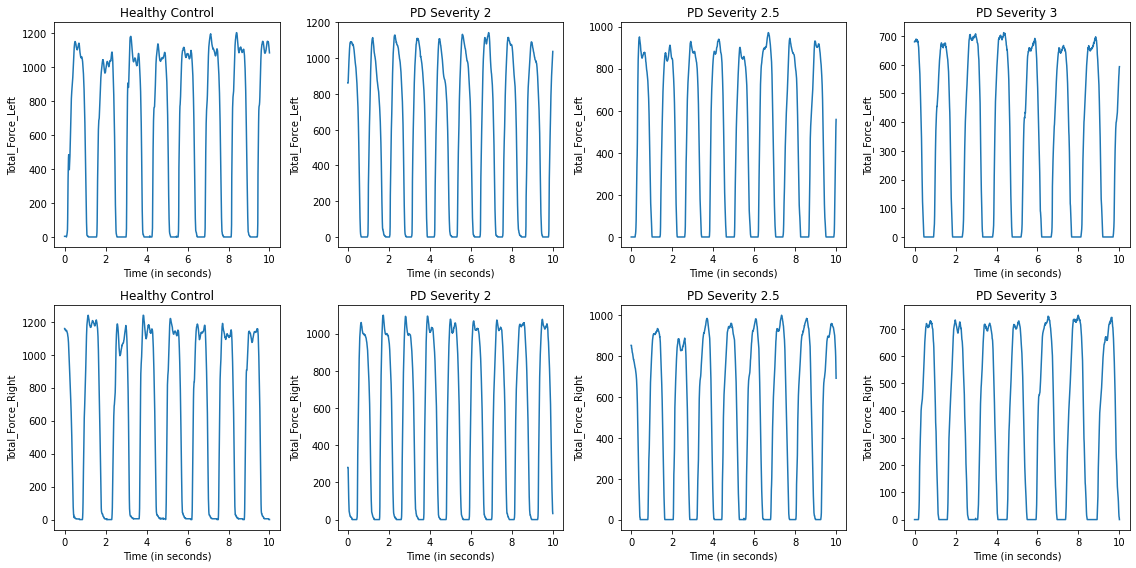

In [6]:
nrows = 2
ncols = 4
subjects = ['GaCo03_01', 'GaPt06_01', 'GaPt04_01', 'GaPt03_01']
category = ['Healthy Control', 'PD Severity 2', 'PD Severity 2.5', 'PD Severity 3']

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

i = 0
for sub in subjects:
  df = pd.read_csv('CSV/' + sub + '.csv').head(1001)
  i += 1
  for j, fname in enumerate(['Total_Force_Left', 'Total_Force_Right']):
    plt.subplot(nrows, ncols, i + (j*4))
    plt.tight_layout()
    plt.plot(df.Time, df[fname])
    plt.xlabel('Time (in seconds)')
    plt.ylabel(fname)
    plt.title(category[i-1])
    
plt.show()

## Preprocess the dataset

### Demographics

In [7]:
demographics = pd.read_csv('Physionet/demographics.txt', delim_whitespace=True)
sub_id = demographics.ID.to_list()
sub_names = []
for name in os.listdir('CSV'):
  sub_name = name.split('_')[0]
  sub_names.append(sub_name)

print("Subjects Count (in demographics) = ", len(sub_id))
print("Files count = ", len(sub_names))

Subjects Count (in demographics) =  166
Files count =  306


### Preprocessing HoehnYahr Feature
- Filling the missing data
- Changing the classes 

| HY Score | Class |
|----------|-------|
| 0.0 | 0 |
| 2.5 | 1 |
| 2.0 | 2 |
| 3.0 | 3 |

In [8]:
demographics.HoehnYahr
demographics['HoehnYahr'] = demographics['HoehnYahr'].fillna(0)
demographics.HoehnYahr.value_counts()

0.0    73
2.0    55
2.5    28
3.0    10
Name: HoehnYahr, dtype: int64

In [9]:
# Remove the demographics of missing file
demographics = demographics[demographics.ID != 'Juc010']
print("Subject Count from different Study")
print(demographics.Study.value_counts())

print("\nSubject Count - Study & Gender")
print(pd.crosstab(demographics.Study, demographics.Gender))

print("\nSubject Count - Study & Groups")
print(pd.crosstab(demographics.Study, demographics.Group))

print("\nSubject Count - Groups & Gender")
print(pd.crosstab(demographics.Group, demographics.Gender))

print("\nSubject Count - Study + Groups & Gender")
print(pd.crosstab([demographics.Study, demographics.Group], demographics.Gender))

print("\nSubject Count - Study Group & HoehnYahr Severity")
print(pd.crosstab(demographics.Study, demographics.HoehnYahr))

Subject Count from different Study
Si    64
Ju    54
Ga    47
Name: Study, dtype: int64

Subject Count - Study & Gender
Gender   1   2
Study         
Ga      30  17
Ju      28  26
Si      40  24

Subject Count - Study & Groups
Group   1   2
Study        
Ga     29  18
Ju     29  25
Si     35  29

Subject Count - Groups & Gender
Gender   1   2
Group         
1       58  35
2       40  32

Subject Count - Study + Groups & Gender
Gender        1   2
Study Group        
Ga    1      20   9
      2      10   8
Ju    1      16  13
      2      12  13
Si    1      22  13
      2      18  11

Subject Count - Study Group & HoehnYahr Severity
HoehnYahr  0.0  2.0  2.5  3.0
Study                        
Ga          18   15    8    6
Ju          25   12   13    4
Si          29   28    7    0


In [10]:
demographics['HoehnYahr'].replace({2.5: 1}, inplace=True)
demographics['HoehnYahr'] = demographics['HoehnYahr'].astype(int)
demographics.HoehnYahr.value_counts()

0    72
2    55
1    28
3    10
Name: HoehnYahr, dtype: int64

## Segmentation of the Data
- Each segment will be of the shape 100 x 19

In [11]:
!mkdir Final
!mkdir Final/train
!mkdir Final/test

count = len(os.listdir('CSV'))
train_count = int(70/100*count)
test_count = count - train_count

print("Training Count Subjects = ", train_count)
print("Test Count Subjects = ", test_count)

category = 'train'
counter = 1

ypath = 'Final/y_' + category + '.txt'
yfile = open(ypath, "a")
hypath = 'Final/hyscore_' + category + '.txt'
hyfile = open(hypath, "a")

for name in os.listdir('CSV'):
  if counter == train_count + 1:
    yfile.flush()
    yfile.close()
    hyfile.flush()
    hyfile.close()
    
    category = 'test'    
    ypath = 'Final/y_' + category + '.txt'
    yfile = open(ypath, "a")
    hypath = 'Final/hyscore_' + category + '.txt'
    hyfile = open(hypath, "a")
  print(counter, name, category)
  
  sub_name = name.split('_')[0]
  sub_class = demographics[demographics['ID'] == sub_name]['Group'].to_string(index=False).strip()
  hy_class = demographics[demographics['ID'] == sub_name]['HoehnYahr'].to_string(index=False).strip()
  sub_data = pd.read_csv('CSV/' + name)
  features = sub_data.columns.to_list()
  
  for i in range(0, sub_data.shape[0], 100):
    if sub_data.shape[0] >= i+100:
      yfile.write(sub_class + "\n")
      hyfile.write(hy_class + "\n")
      
      for fname in features:
        path_name = 'Final/' + category + '/'
        file_name = fname + '_' + category + '.txt'
        with open(path_name + file_name, 'a') as feat_file:
          arr = sub_data.iloc[i:i+100, ][fname].to_numpy()
          # print(i, len(arr), end = ' | ')
          feat_file.write(' '.join(map(str, arr)) + "\n")

  counter = counter + 1
yfile.flush()
yfile.close()
hyfile.flush()
yfile.close()

Training Count Subjects =  214
Test Count Subjects =  92
1 JuPt27_01.csv train
2 GaPt21_10.csv train
3 JuPt29_03.csv train
4 GaPt27_01.csv train
5 SiPt40_01.csv train
6 GaPt15_01.csv train
7 SiPt14_01.csv train
8 GaPt27_10.csv train
9 JuPt10_07.csv train
10 JuPt20_04.csv train
11 SiPt16_01.csv train
12 JuPt11_04.csv train
13 JuCo17_01.csv train
14 SiPt19_01.csv train
15 SiCo05_01.csv train
16 SiPt09_01.csv train
17 GaPt13_02.csv train
18 GaPt05_01.csv train
19 GaPt19_01.csv train
20 GaPt29_02.csv train
21 JuPt28_03.csv train
22 GaPt07_02.csv train
23 GaPt13_10.csv train
24 GaCo15_10.csv train
25 JuPt03_01.csv train
26 JuPt01_01.csv train
27 GaCo10_01.csv train
28 JuPt21_03.csv train
29 GaCo09_02.csv train
30 JuCo18_01.csv train
31 GaPt17_10.csv train
32 JuPt06_03.csv train
33 GaPt22_02.csv train
34 SiCo19_01.csv train
35 SiCo01_01.csv train
36 JuPt26_04.csv train
37 SiCo28_01.csv train
38 JuPt10_05.csv train
39 JuCo01_01.csv train
40 GaCo07_01.csv train
41 JuPt10_02.csv train
42 JuPt29

## Load Dataset - Training and Testing

In [12]:
def load_file(filepath):
	dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values

# load a list of files into a 3D array of [samples, timesteps, features]
def load_category(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = np.dstack(loaded)
	return loaded


# load a dataset category, such as train or test
def load_dataset_category(category, prefix=''):
	# load all 19 files as a single array
	filenames = []
	for fname in features:
		filenames.append(category + '/' + fname + '_' + category + '.txt')
  
	# load input data
	X = load_category(filenames, prefix)
	# load class output
	y = load_file(prefix + 'y_'+ category +'.txt')
	hy = load_file(prefix + 'hyscore_'+ category +'.txt')
	return X, y, hy

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	trainX, trainy, trainHY = load_dataset_category('train', prefix)
	print(trainX.shape, trainy.shape, trainHY.shape)
	# load all test
	testX, testy, testHY = load_dataset_category('test', prefix)
	print(testX.shape, testy.shape, testHY.shape)
 
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = tf.keras.utils.to_categorical(trainy)
	trainHY = tf.keras.utils.to_categorical(trainHY)
	testy = tf.keras.utils.to_categorical(testy)
	testHY = tf.keras.utils.to_categorical(testHY)  
 
	# print(trainX.shape, trainy.shape, trainHY.shape, testX.shape, testy.shape, testHY.shape)
	return trainX, trainy, trainHY, testX, testy, testHY

In [13]:
trainX, trainy, trainHY, testX, testy, testHY = load_dataset('Final/')
print("Training Data = ", trainX.shape)
print("Training Class = ", trainy.shape)
print("Training HoehnYahr Class = ", trainHY.shape)
print("Test Data = ", testX.shape)
print("Test Class = ", testy.shape)
print("Test HoehnYahr Class = ", testHY.shape)

(23436, 100, 19) (23436, 1) (23436, 1)
(9643, 100, 19) (9643, 1) (9643, 1)
Training Data =  (23436, 100, 19)
Training Class =  (23436, 2)
Training HoehnYahr Class =  (23436, 4)
Test Data =  (9643, 100, 19)
Test Class =  (9643, 2)
Test HoehnYahr Class =  (9643, 4)


## Detection of PD
- PD - 0
- Control - 1

### PD Model

In [61]:
verbose, epochs, batch_size = 1, 500, 32
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

DESIRED_ACCURACY = 0.95

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > DESIRED_ACCURACY:
      print("Reached " + str(DESIRED_ACCURACY*100)  + "% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(100, activation='relu'))
model.add(tf.keras.layers.Dense(n_outputs, activation='softmax'))

model.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics =[tf.keras.metrics.TruePositives(name='tp'),
                        tf.keras.metrics.FalsePositives(name='fp'),
                        tf.keras.metrics.TrueNegatives(name='tn'),
                        tf.keras.metrics.FalseNegatives(name='fn'),
                        'accuracy',
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(name='auc')])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 98, 64)            3712      
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 96, 64)            12352     
_________________________________________________________________
dropout_9 (Dropout)          (None, 96, 64)            0         
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 48, 64)            0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 100)               307300    
_________________________________________________________________
dense_19 (Dense)             (None, 2)                

### Train the model

In [62]:
PD_history = model.fit(trainX,
                       trainy,
                       validation_data=(testX, testy),
                       epochs = epochs,
                       batch_size = batch_size,
                       verbose = verbose,
                       callbacks = [callbacks])

Epoch 1/500
733/733 [==============================] - 15s 19ms/step - loss: 1.4229 - tp: 17249.0000 - fp: 6187.0000 - tn: 17249.0000 - fn: 6187.0000 - accuracy: 0.7360 - precision: 0.7360 - recall: 0.7360 - auc: 0.7934 - val_loss: 0.5057 - val_tp: 7382.0000 - val_fp: 2261.0000 - val_tn: 7382.0000 - val_fn: 2261.0000 - val_accuracy: 0.7655 - val_precision: 0.7655 - val_recall: 0.7655 - val_auc: 0.8363
Epoch 2/500
733/733 [==============================] - 13s 18ms/step - loss: 0.4387 - tp: 19013.0000 - fp: 4423.0000 - tn: 19013.0000 - fn: 4423.0000 - accuracy: 0.8113 - precision: 0.8113 - recall: 0.8113 - auc: 0.8836 - val_loss: 0.4745 - val_tp: 7846.0000 - val_fp: 1797.0000 - val_tn: 7846.0000 - val_fn: 1797.0000 - val_accuracy: 0.8136 - val_precision: 0.8136 - val_recall: 0.8136 - val_auc: 0.8657
Epoch 3/500
733/733 [==============================] - 13s 18ms/step - loss: 0.3683 - tp: 19857.0000 - fp: 3579.0000 - tn: 19857.0000 - fn: 3579.0000 - accuracy: 0.8473 - precision: 0.8473 -

### Save the Model

In [63]:
model.save("/content/drive/MyDrive/College Related/Project Work 1 - Sem 7/Saved Models/PD_Model.h5")
print("PD_Model saved Successfully!")

PD_Model saved Successfully!


### Plot the graphs

In [64]:
# Plot the accuracy and loss functions
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

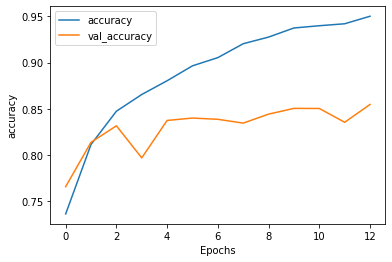

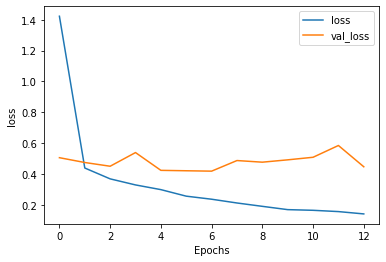

In [65]:
plot_graphs(PD_history, "accuracy")
plot_graphs(PD_history, "loss")

### Evaluation of Model

In [66]:
def model_evaluate(model, target, testX, testy):
  y_pred = model.predict(testX)
  y_pred = np.argmax(y_pred, axis=1)
  y_test = np.argmax(testy, axis=1)

  # Confusion matrix
  print('Confusion Matrix')

  cm = tf.math.confusion_matrix(labels = y_test, predictions = y_pred)
  # Calculate accuracy
  cm_np = cm.numpy()
  conf_acc = (cm_np[0, 0] + cm_np[1, 1])/ np.sum(cm_np) * 100
  print("Accuracy for Test Data = ", conf_acc)

  plt.figure(figsize = (12,8))
  seaborn.heatmap(cm, annot=True, fmt='d')
  plt.title("Confusion Matrix for Test Data")
  plt.xlabel('Predicted')
  plt.ylabel('Expected')
  plt.show()

  # Classification Report
  print('\nClassification Report')
  print(classification_report(y_test, y_pred))

  # Cohen Kappa Score
  print('\nCohen Kappa Score')
  print(cohen_kappa_score(y_test, y_pred))

  # Precision vs Recall Curve
  print('\nPrecision vs Recall Curve')
  fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

  y_test = tf.keras.utils.to_categorical(y_test)
  y_pred = tf.keras.utils.to_categorical(y_pred)
  n_classes = 2

  precision = dict()
  recall = dict()

  for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                          y_pred[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
      
  plt.xlabel("recall")
  plt.ylabel("precision")
  plt.legend(loc="best")
  plt.title("Precision vs. Recall curve")
  plt.show()

  # ROC Curve
  print('\nROC Curve')
  average = 'macro'
  fig, c_ax = plt.subplots(1,1, figsize = (12, 8))
  for (idx, c_label) in enumerate(target):
      fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
      c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
  c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
  print('ROC AUC score:', roc_auc_score(y_test, y_pred, average=average))

  c_ax.legend()
  c_ax.set_xlabel('False Positive Rate')
  c_ax.set_ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.show()

Confusion Matrix
Accuracy for Test Data =  85.4609561339832


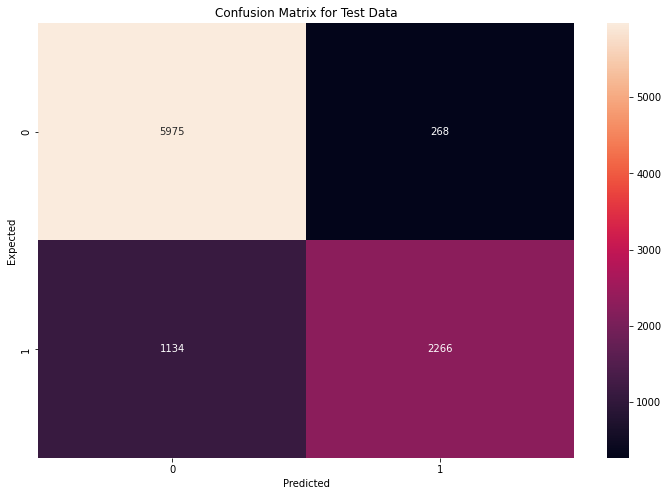


Classification Report
              precision    recall  f1-score   support

           0       0.84      0.96      0.89      6243
           1       0.89      0.67      0.76      3400

    accuracy                           0.85      9643
   macro avg       0.87      0.81      0.83      9643
weighted avg       0.86      0.85      0.85      9643


Cohen Kappa Score
0.6619313923689913

Precision vs Recall Curve


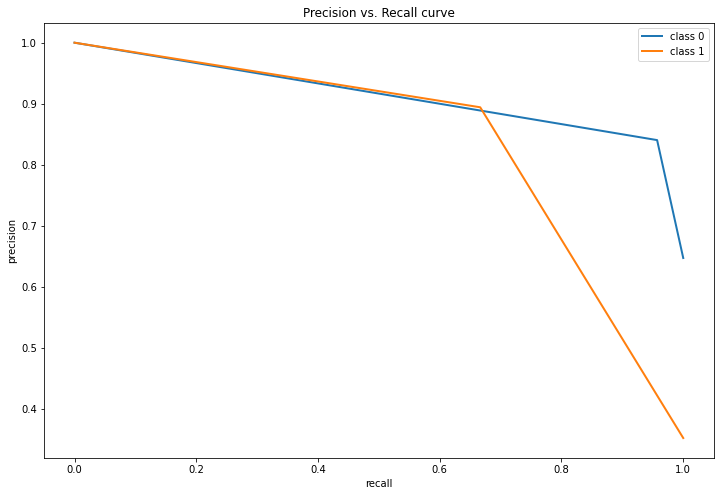


ROC Curve
ROC AUC score: 0.8117712543931557


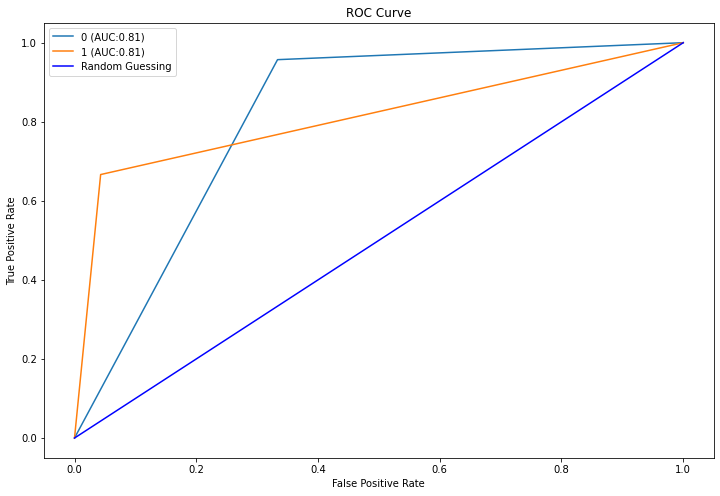

In [67]:
model_evaluate(model, [0,1], testX, testy)

## Classification based on HoehnYahr Score

### HY Model

In [68]:
verbose, epochs, batch_size = 1, 500, 32
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainHY.shape[1]

callbacks = myCallback()
HYmodel = tf.keras.models.Sequential()
HYmodel.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
HYmodel.add(tf.keras.layers.MaxPooling1D(pool_size=2))
HYmodel.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
HYmodel.add(tf.keras.layers.MaxPooling1D(pool_size=2))
HYmodel.add(tf.keras.layers.Dropout(0.5))
HYmodel.add(tf.keras.layers.Flatten())
HYmodel.add(tf.keras.layers.Dense(100, activation='relu'))
HYmodel.add(tf.keras.layers.Dense(n_outputs, activation='softmax'))

HYmodel.compile(loss = 'categorical_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), 
              metrics =[tf.keras.metrics.TruePositives(name='tp'),
                        tf.keras.metrics.FalsePositives(name='fp'),
                        tf.keras.metrics.TrueNegatives(name='tn'),
                        tf.keras.metrics.FalseNegatives(name='fn'),
                        'accuracy',
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(name='auc')])
HYmodel.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 98, 64)            3712      
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 49, 64)            0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 47, 64)            12352     
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 23, 64)            0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 23, 64)            0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 1472)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 100)             

### Train the model

In [69]:
HY_history = HYmodel.fit(trainX,
                        trainHY,
                        validation_data=(testX, testHY),
                        epochs = epochs, 
                        batch_size = batch_size, 
                        verbose = verbose,
                        callbacks = [callbacks])

Epoch 1/500
733/733 [==============================] - 12s 14ms/step - loss: 17.5358 - tp: 7695.0000 - fp: 14874.0000 - tn: 55434.0000 - fn: 15741.0000 - accuracy: 0.3385 - precision: 0.3410 - recall: 0.3283 - auc: 0.5795 - val_loss: 1.4753 - val_tp: 2431.0000 - val_fp: 2849.0000 - val_tn: 26080.0000 - val_fn: 7212.0000 - val_accuracy: 0.3794 - val_precision: 0.4604 - val_recall: 0.2521 - val_auc: 0.6514
Epoch 2/500
733/733 [==============================] - 9s 13ms/step - loss: 1.3702 - tp: 4063.0000 - fp: 4600.0000 - tn: 65708.0000 - fn: 19373.0000 - accuracy: 0.3963 - precision: 0.4690 - recall: 0.1734 - auc: 0.6744 - val_loss: 1.2067 - val_tp: 1303.0000 - val_fp: 790.0000 - val_tn: 28139.0000 - val_fn: 8340.0000 - val_accuracy: 0.4538 - val_precision: 0.6226 - val_recall: 0.1351 - val_auc: 0.7187
Epoch 3/500
733/733 [==============================] - 9s 13ms/step - loss: 1.1755 - tp: 3984.0000 - fp: 2777.0000 - tn: 67531.0000 - fn: 19452.0000 - accuracy: 0.4493 - precision: 0.5893 

### Save the model

In [70]:
HYmodel.save("/content/drive/MyDrive/College Related/Project Work 1 - Sem 7/Saved Models/HY_Model.h5")
print("HY_Model saved Successfully!")

HY_Model saved Successfully!


In [ ]:
HYmodel = keras.models.load_model("/content/drive/MyDrive/College Related/Project Work 1 - Sem 7/Saved Models/HY_Model.h5")

### Plot the graphs

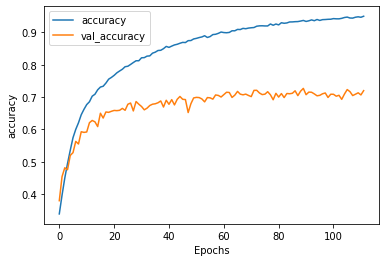

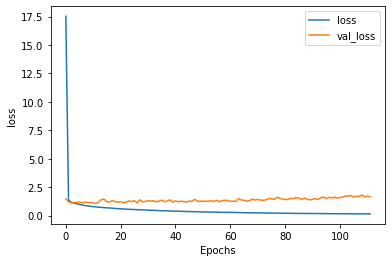

In [71]:
plot_graphs(HY_history, "accuracy")
plot_graphs(HY_history, "loss")

### Evaluation of Model

Confusion Matrix
Accuracy for Test Data =  49.98444467489371


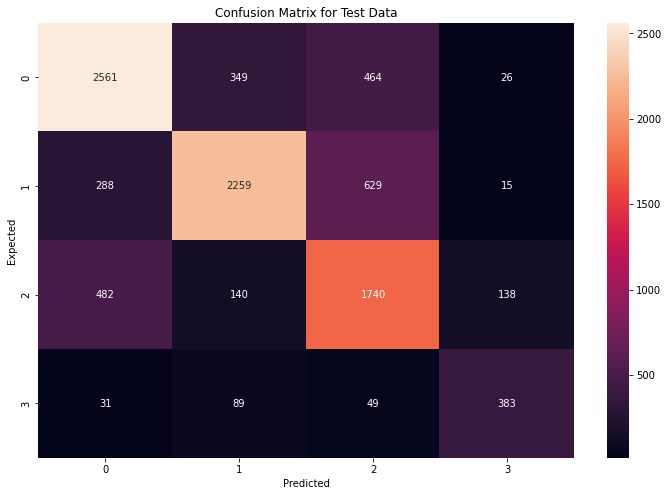


Classification Report
              precision    recall  f1-score   support

           0       0.76      0.75      0.76      3400
           1       0.80      0.71      0.75      3191
           2       0.60      0.70      0.65      2500
           3       0.68      0.69      0.69       552

    accuracy                           0.72      9643
   macro avg       0.71      0.71      0.71      9643
weighted avg       0.73      0.72      0.72      9643


Cohen Kappa Score
0.5993740928980145

Precision vs Recall Curve


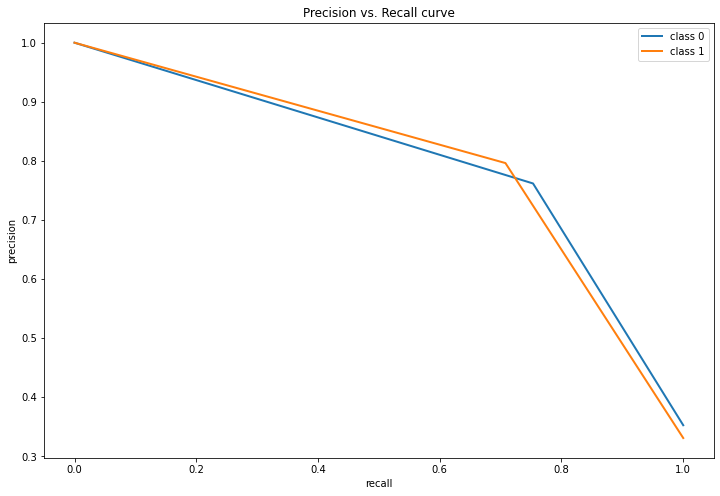


ROC Curve
ROC AUC score: 0.8066936865299241


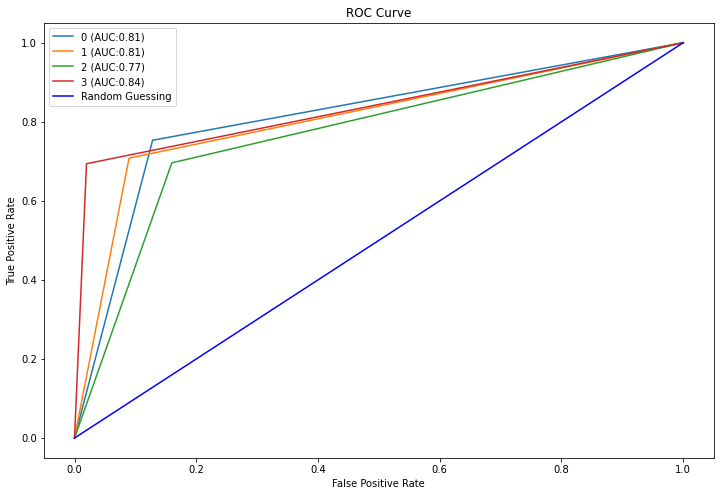

In [74]:
model_evaluate(HYmodel, [0, 1, 2, 3], testX, testHY)